In [1]:
import os
import sys
sys.path.append('../examples')
sys.path.append('../jobs')
sys.path.append('../training_data')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config

import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


# 1. Probability mass captured by the top 256, 512 tokens

512 tokens seems to have the desired effect. Across 300k contexts, we observe that the top 512 tokens capture 90.7% of the probability mass on average

In [2]:
def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

vocab_size = tokenizer.vocab_size

In [14]:
def getDistr(k, file_path):
    probs = []
    with open(file_path) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            if len(context) > 100:
                continue
            context = torch.tensor(context, dtype=torch.long, device=device).unsqueeze(0)
            inputs = {'input_ids': context}
            outputs = model(**inputs)  # Note: we could also use 'past' with GPT-2/Transfo-XL/XLNet (cached hidden-states)
            model_next_logits = outputs[0][:, -1, :]
            next_probs = F.softmax(model_next_logits, dim=-1)[0].detach().cpu().numpy()
            sorted_probs = np.sort(next_probs)[::-1]
            probs.append(sorted_probs[:k].sum())          
    return probs

In [3]:
file = '../training_data/gbw/training/news.en-00001-of-00100'
k = 256

probs = []
with open(file) as fp:
    for line in fp:
        context = tokenizer.encode(line)
        if len(context) > 100:
            continue
        context = torch.tensor(context, dtype=torch.long, device=device).unsqueeze(0)
        inputs = {'input_ids': context}
        outputs = model(**inputs)  # Note: we could also use 'past' with GPT-2/Transfo-XL/XLNet (cached hidden-states)
        model_next_logits = outputs[0][:, -1, :]
        next_probs = F.softmax(model_next_logits, dim=-1)[0].detach().cpu().numpy()
        sorted_probs = np.sort(next_probs)[::-1]
        probs.append(sorted_probs[:k].sum())

(array([4.40000e+01, 1.29000e+02, 3.60000e+02, 8.25000e+02, 1.99800e+03,
        4.80900e+03, 1.91630e+04, 1.02244e+05, 1.45797e+05, 2.96720e+04]),
 array([0.35009176, 0.41508225, 0.48007274, 0.54506326, 0.6100537 ,
        0.67504424, 0.74003476, 0.8050252 , 0.87001574, 0.9350062 ,
        0.9999967 ], dtype=float32),
 <a list of 10 Patch objects>)

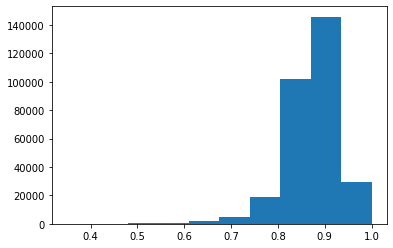

In [4]:
plt.hist(probs)

In [9]:
probs = np.array(probs)
greater = np.ones(len(probs))
greater[probs < 0.8] = 0
pct = greater.sum() / len(probs)
print(pct)

0.9200632046183955


In [10]:
np.mean(probs)

0.8725204

In [6]:
np.savez('top256_prob_mass', p=probs)

In [15]:
# mass 512

file = '../training_data/gbw/training/news.en-00001-of-00100'
k = 512
probs = getDistr(k, file)

In [4]:
probs = np.load('top512_prob_mass.npz')['p']

Text(0, 0.5, 'Frequency')

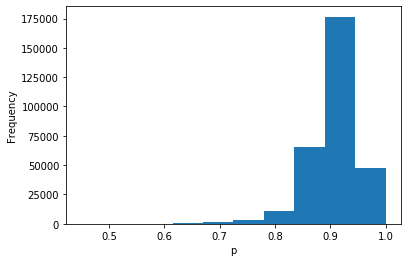

In [5]:
plt.hist(probs)
plt.xlabel('p')
plt.ylabel('Frequency')

In [17]:
probs = np.array(probs)
greater = np.ones(len(probs))
greater[probs < 0.9] = 0
pct = greater.sum() / len(probs)
print(pct)

0.6429856970046649


In [18]:
np.mean(probs)

0.90724313

In [20]:
np.median(probs)

0.9128227

In [19]:
np.savez('top512_prob_mass', p=probs)

# 2. Entropy blowup for GBW sentences

Text(0.5, 1.0, 'Entropy blowup s1')

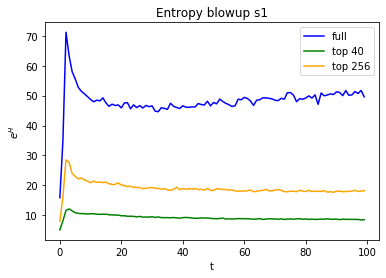

In [24]:
data_full = np.load('../jobs/results/entropy-s1/result.npz')['avg_ents'][0]
data_40 = np.load('../jobs/results/e40-s1/result.npz')['avg_ents'][0]
data_256 = np.load('../jobs/results/e256-s1/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_full), c='blue', label='full')
plt.plot(np.exp(data_40), c='green', label='top 40')
plt.plot(np.exp(data_256), c='orange', label='top 256')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup s1')

Text(0.5, 1.0, 'Entropy blowup s2')

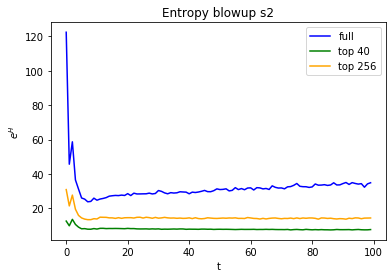

In [25]:
data_full = np.load('../jobs/results/entropy-s2/result.npz')['avg_ents'][0]
data_40 = np.load('../jobs/results/e40-s2/result.npz')['avg_ents'][0]
data_256 = np.load('../jobs/results/e256-s2/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_full), c='blue', label='full')
plt.plot(np.exp(data_40), c='green', label='top 40')
plt.plot(np.exp(data_256), c='orange', label='top 256')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup s2')

Text(0.5, 1.0, 'Entropy blowup s3')

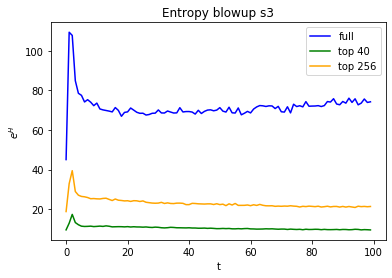

In [26]:
data_full = np.load('../jobs/results/entropy-s3/result.npz')['avg_ents'][0]
data_40 = np.load('../jobs/results/e40-s3/result.npz')['avg_ents'][0]
data_256 = np.load('../jobs/results/e256-s3/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_full), c='blue', label='full')
plt.plot(np.exp(data_40), c='green', label='top 40')
plt.plot(np.exp(data_256), c='orange', label='top 256')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup s3')

Text(0.5, 1.0, 'Entropy blowup s4')

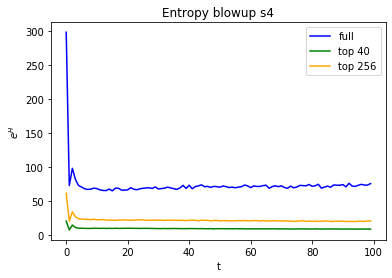

In [27]:
data_full = np.load('../jobs/results/entropy-s4/result.npz')['avg_ents'][0]
data_40 = np.load('../jobs/results/e40-s4/result.npz')['avg_ents'][0]
data_256 = np.load('../jobs/results/e256-s4/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_full), c='blue', label='full')
plt.plot(np.exp(data_40), c='green', label='top 40')
plt.plot(np.exp(data_256), c='orange', label='top 256')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup s4')

Text(0.5, 1.0, 'Entropy blowup s5')

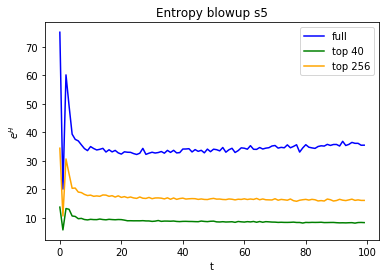

In [28]:
data_full = np.load('../jobs/results/entropy-s5/result.npz')['avg_ents'][0]
data_40 = np.load('../jobs/results/e40-s5/result.npz')['avg_ents'][0]
data_256 = np.load('../jobs/results/e256-s5/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_full), c='blue', label='full')
plt.plot(np.exp(data_40), c='green', label='top 40')
plt.plot(np.exp(data_256), c='orange', label='top 256')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup s5')

Text(0.5, 1.0, 'Entropy blowup post 20')

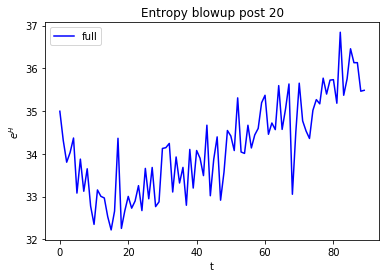

In [32]:
plt.plot(np.exp(data_full[10:]), c='blue', label='full')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup post 20')

Text(0.5, 1.0, 'Entropy blowup post 20')

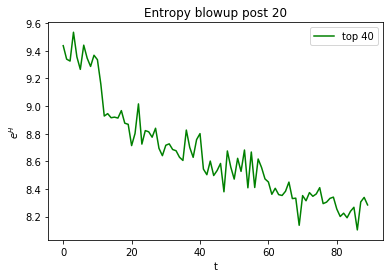

In [33]:
plt.plot(np.exp(data_40[10:]), c='green', label='top 40')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup post 20')

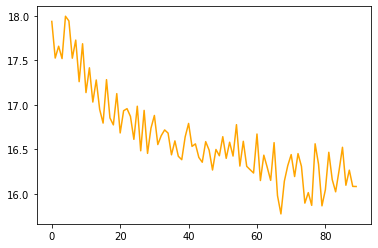

In [34]:
plt.plot(np.exp(data_256[10:]), c='orange', label='top 256')

# 3. Calibration results

In [36]:
alpha = np.load('../jobs/results/full-cal-h100/result.npz')['alpha']
print(alpha)

-0.11912959814071655


In [11]:
alpha = np.load('../jobs/results/calibrate-top256/result.npz')['alpha']
print(alpha)

-0.9590018391609192


In [12]:
alpha = np.load('../jobs/results/calibrate-top512/result.npz')['alpha']
print(alpha)

-0.47574692964553833


Text(0.5, 1.0, 'Entropy blowup s5')

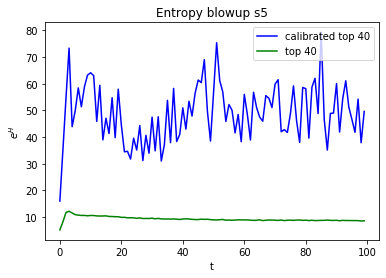

In [4]:
gen40 = np.load('../jobs/results/gen-cal40/result.npz')['avg_ents'][0]
data_40 = np.load('../jobs/results/e40-s1/result.npz')['avg_ents'][0]
plt.plot(np.exp(gen40), c='blue', label='calibrated top 40')
plt.plot(np.exp(data_40), c='green', label='top 40')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup s5')

Text(0.5, 1.0, 'Entropy blowup s5')

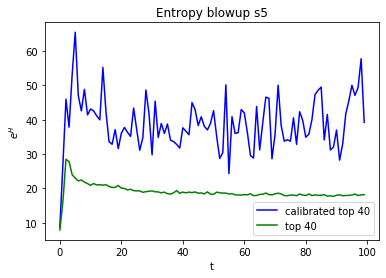

In [9]:
gen512 = np.load('../jobs/results/gen-cal512/result.npz')['avg_ents'][0]
data_40 = np.load('../jobs/results/e40-s1/result.npz')['avg_ents'][0]
plt.plot(np.exp(gen512), c='blue', label='calibrated top 40')
plt.plot(np.exp(data_256), c='green', label='top 40')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup s5')

Text(0.5, 1.0, 'Entropy blowup s1')

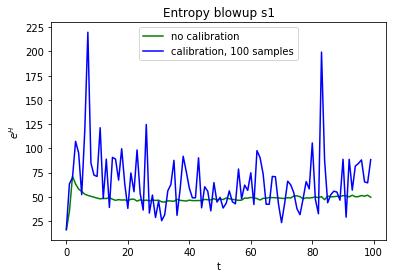

In [13]:
data_full = np.load('../jobs/results/entropy-s1/result.npz')['avg_ents'][0]
gen_full = np.load('../jobs/results/gen-cal-full/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_full), c='green', label='no calibration')
plt.plot(np.exp(gen_full), c='blue', label='calibration, 100 samples')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup s1')